# Исследование рынка игр

## Описание работы

Основная задача данного исследования — выявить факторы, определающие успешность игр. Это необходимо для того, чтобы  сделать ставку на потенциально популярный продукт и спланировать рекламные кампании в нашем магазине.

## План работы

В рамках выполнения данной работы я буду придерживаться следующего плана: 
1. [Подготовка данных](#prep)
2. [Исследовательский анализ](#issledovanie)
3. [Составление портрета пользователя для каждого региона](#portrait)
4. [Исследование статистических показателей](#stat)
5. [Проверка гипотиз](#hyp)


## Описание данных

В таблице представлены следующие столбцы: 
1. Name — название игры
2. Platform — платформа
3. Year_of_Release — год выпуска
4. Genre — жанр игры
5. NA_sales — продажи в Северной Америке (миллионы долларов)
6. EU_sales — продажи в Европе (миллионы долларов)
7. JP_sales — продажи в Японии (миллионы долларов)
8. Other_sales — продажи в других странах (миллионы долларов)
9. Critic_Score — оценка критиков (от 0 до 100)
10. User_Score — оценка пользователей (от 0 до 10)
11. Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.stats import norm

# Шаг 2. Общая информация о данных

Открываем файл и получаем общую информацию о данных

In [2]:
df = pd.read_csv('/datasets/games.csv')
print(df.info()) #общая информация о таблице
print(df.columns) #названия столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


В основной части таблицы пропусков не очень много: по 2 в столбцах "Name" и "Genre", почти 300 пропусков в столбце "Year_of_Release". Однако для таблицы на почти 17 тысяч строк это незначительные потери, возможно, эти данные пропущены случайно. Скорее всего, их можно просто удалить из таблицы.

Большинство пропущенных значений сосредоточены в конце таблицы — в столбцах "Critic_Score" "User_Score" и "Rating". Я думаю, что такое количество пропущенных значений явно не случайное. Возможно, получится заменить пропуски на усредненное значение по столбцу или на нетипичное дл столбца значение.

# Шаг 3. Подготовка данных
<a id='prep'></a>

## Шаг 3.1 Установим удобные названия столбцов

In [3]:
df.rename(columns={'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release',
                   'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 
                   'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score',
                   'User_Score': 'user_score','Rating': 'rating'}, inplace = True)
print(df.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


## Шаг 3.2 Замена типов данных

Производить замену типов данных будем только для двух столбцов.

Первый столбец — "year_of_release". Так как в таблице данные о дате выхода игры указаны с точностью до года, а год — это только целое число, данный столбец можно привести к типу данных "int64" вместо "float64". Для этого сначала очистим столбец от пропущенных значений. 

Второй столбец — "user_score". Данные в этом столбце имеют тип — "float64", однако в таблице он задан как "object". Видимо, дело в значениях "tbd", означающих "to be doing" — "в процессе". Так как для нас не принципиально, почему именно нет пользовательской оценки для игр, то мы просто заменим все "tbd" на "None". К сожалению, без этого шага мы не сможем изменить тип данных столбца.

In [4]:
df['user_score'].replace('tbd', None, inplace = True) #Заменим все tbd на None

df.dropna(subset = ['year_of_release'], inplace = True) #Избавимся от строк, где пропущено значение даты выхода

print('процент значений, содержащих "tbd" в столбце "user_score":{: .1%}'.format((df[df['user_score'] == 'tbd']['user_score'].count()) / ((len(df['user_score'])))))
df.isna().sum()

процент значений, содержащих "tbd" в столбце "user_score": 0.0%


name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         7837
rating             6678
dtype: int64

Теперь, когда данные подготовлены, можно произвести замену типов данных на выбранные.

In [5]:
df = df.astype({'year_of_release': 'int64', 'user_score': 'float64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         8609 non-null float64
rating             9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [6]:
print(df.isna().sum())
print()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         7837
rating             6678
dtype: int64



## Шаг 3.3 Обработка пропусков

Частично мы уже очистили пропуски в таблице, разберемся с остальными

В основной части таблицы пропусков не очень много, но вот в части оценки критиков, пользователей и рейтинга утеряна значительная часть информации. Попробуем обработать и очистить данные.

Для начала обработаем пропуски в столбцах: "name" и "genre". 

In [7]:
print(df[df['name'].isna()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN  


Как мы видим, строки, где пропущены значения в столбцах "name" и "genre" совпадают, так что избавимся от данных строк.

In [8]:
df.dropna(subset = ['genre'], inplace = True)

Данные по рейтингу установить не получится, так что заменим пропуски на "unknown". 

In [9]:
df['rating'] = df['rating'].fillna('unknown')

Обрабатывать пропуски в столбцах "critic_score" и "user_score" не будем.

А теперь объясню, почему я именно так обработал пропуски.

1) "name" и "genre". Так как было пропущенно всего 2 значения из почти 17 тысяч, эти данные не сильно повлияли на аналитику. Проще от них избавиться, чем восстанавливать или обрабатывать данные с пустым значением.

Возможная причина — человеческий фактор. В источнике забыли внести название игры или ввели некорректно.

2) "year_of_release". Пропуски было необходимо удалить для того, чтоб можно было заменить тип данных во всем столбце. Пропусков было не очень много относительно всей таблицы. Конечно, данные возможно было восстановить вручную по названию игры, но это бы заняло много времени, а аналитика должна быть готова вчера)

Возможная причина — отсутствие значений в бд.

3) "rating". Мне удобнее работать с "unknown" чем с пропущенными значениями.

Возможная причина — Рейтинг ESRB ввели в 2005 году, а игры, выпущенные до 2005 года рейтинг не получили. Плюс новые игры, для которых рейтинг еще не установлен.

4) "critic_score" и "user_score". Данные столбцы типа "float64", поэтому заменить на "unknown" не получится. Заменять на нетипичные значения не стал из-за того, что меняются основные вычислияемы значения, на которых можно строить аналитику. От них бы пришлость в дальнейшем избавляться, так что проще оставить пропуски.

На всякий случай проведем простую проверку на наличие дубликатов.

In [10]:
print(df.duplicated().sum())

0


теперь, когда все данные очищены, можно приступать к работе.

## Шаг 3.4 Рассчет суммарных продаж

Добавим столбец с общей суммой продаж по всем регионам.

In [11]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] +df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


# Шаг 4. Исследовательский анализ данных
<a id='issledovanie'></a>

## Шаг 4.1 Количество игр по годам
Для начала посмотрим, сколько игр выпускалось в разные годы.

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


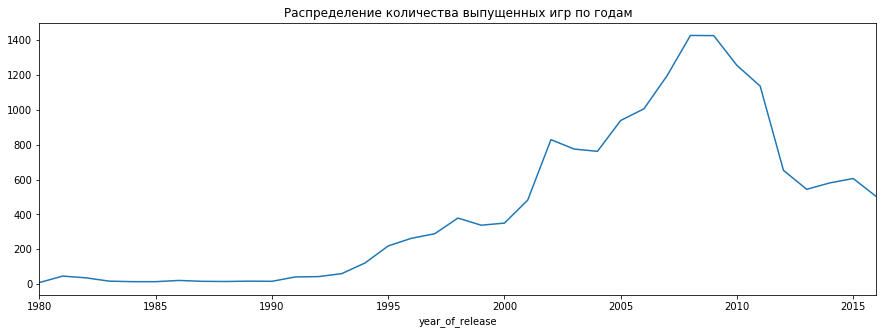

In [12]:
game_by_year = df.groupby('year_of_release')['name'].count()
print(game_by_year)

plot_by_year = game_by_year.plot(title='Распределение количества выпущенных игр по годам', figsize=(15,5))

Если говорить в целом о всей индустрии игровых платформ, судя по данному графику, можно выдвинуть предположение, что рынок игр для консолей поредел. Пик по объемам был с 2006 по 2011, где выпускалось свыше тысячи игр ежегодно. Однако в дальнейшем качество игр заменило их количество. ВОзможно, какую-то роль сыграл спрос потребителей на качество игр. До этого в индустрии прогресс в качестве игр можно было наблюдать ежегодно. Однако к второму десятилетию двухтысячных ресурс подисчерпался и нечем было удивлять пользователей. Приходилось тратить больше времени на проработку одной игры, поэтому количество выпускаемых игр в год упало. 

Или, возможно, сказался мировой кризис 2008 года и некоторые компании не смогли пережить эти трудные для них времена.

## Шаг 4.2 Разбивка продаж игр по платформам

Для начала выберем те консоли, для которых будем проводить исследование.

In [13]:
# создадим сводную таблицу, где индексом будет 
# название платформы, а значением сумма продаж всех игр для этой платформы и выведем ее на экран
pt = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
print(pt.sort_values('total_sales', ascending = False))

# для исследования возьмем консоли с суммой продаж выше 100
# и WiiU, так как она относится к консолям нового поколения
pt_sorted = pt[pt['total_sales'] > 80]
print(pt_sorted.sort_values('total_sales', ascending = False))

          total_sales
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78
PS             727.58
PS4            314.14
GBA            312.88
PSP            289.53
3DS            257.81
PC             255.76
GB             254.43
XB             251.57
NES            251.05
N64            218.01
SNES           200.04
GC             196.73
XOne           159.32
2600            86.48
WiiU            82.19
PSV             53.81
SAT             33.59
GEN             28.35
DC              15.95
SCD              1.86
NG               1.44
WS               1.42
TG16             0.16
3DO              0.10
GG               0.04
PCFX             0.03
          total_sales
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78
PS             727.58
PS4            314.14
GBA            312.88
PSP            289.53
3DS            257.81
PC        

Теперь, имея список консолей, по которым мы будем строить график, подготовим таблицу.

[Text(0, 0.5, 'продажи, млн долларов'), Text(0.5, 0, 'год')]

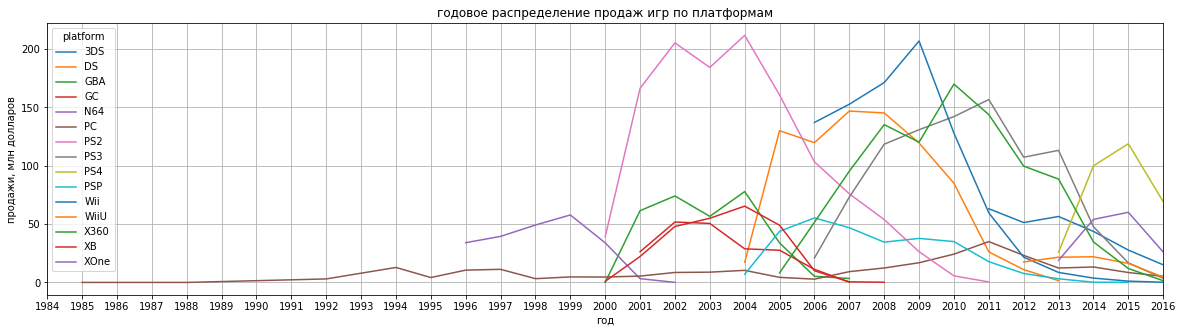

In [14]:
# Для начала из таблицы df методом querry выберем только те строки, которые соответсвтуют выбранным консолям
# Затем методом loc выберем только нужные столбцы
platform_sorted = (df.query('platform in ("PS2", "PS3", "X360", "DS", "Wii", "PS4", "GBA", "PSP", "3DS", "XB", "PC", "GC", "XOne", "N64", "WiiU")')
                   .loc[:, ['platform', 'year_of_release', 'total_sales']]
                  )

# Затем построим сводную таблицу, где индексами будут годы, столбцами — платформы, а значениями — суммы продаж. 
# И построим график методом plot с параметром kind = 'line'.
plot = (
    pd.pivot_table(platform_sorted, values='total_sales', 
                   index='year_of_release', columns=['platform'], aggfunc=sum)
    .plot(kind = 'line', grid=True, figsize=(20, 5), 
                    title = 'годовое распределение продаж игр по платформам')
    )
# Установим шаг по оси x
plot.set_xticks(np.arange(1984,2017,1))
# И названия осей
plot.set(xlabel="год", ylabel="продажи, млн долларов")

Посмотрим подробнее на платформы, для которых в 2016 году уровень продаж еще не на нуле. Выберем в соответствии с предыдущим графиком.

[Text(0, 0.5, 'продажи, млн долларов'), Text(0.5, 0, 'год')]

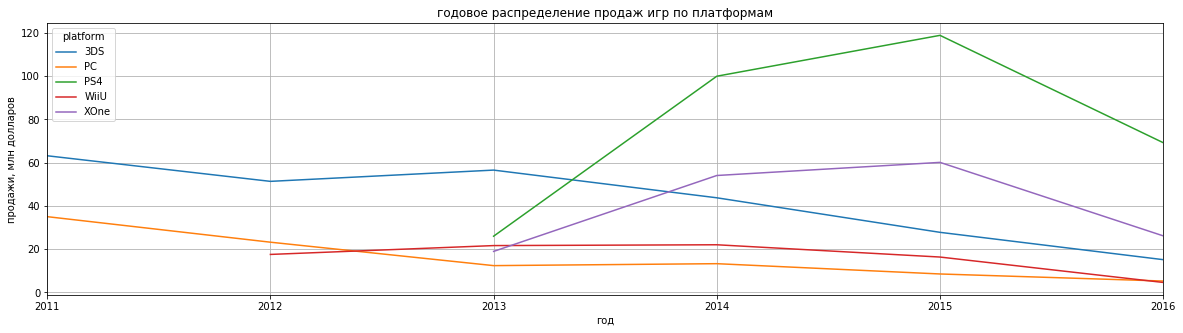

In [15]:
# Ограничим таблицу 2010 годом, чтоб не рассматривать лишние данные
# Аналогично из таблицы df методом querry выберем только те строки, которые соответсвтуют выбранным консолям
# Затем методом loc выберем только нужные столбцы
df_sorted = df[df['year_of_release'] > 2010]
platform_sorted = (df_sorted.query('platform in ("PS4", "3DS", "PC", "XOne", "WiiU")')
                   .loc[:, ['platform', 'year_of_release', 'total_sales']]
                   )
# Построим аналогичную сводную таблицу, график. Установим границы и шаг по оси х и названия осей.
plot = (
    pd.pivot_table(platform_sorted, values='total_sales', 
                   index='year_of_release', columns=['platform'], aggfunc=sum)
    .plot(kind = 'line', grid=True, figsize=(20, 5), 
                    title = 'годовое распределение продаж игр по платформам')
    )
plot.set_xticks(np.arange(2011,2017,1))
plot.set(xlabel="год", ylabel="продажи, млн долларов")

Проведем рассчет среднего времени жизни платформы

In [16]:
#создадим пустые датафреймы
lifetime_min = []
lifetime_max = []

#сохраним в них значения первого и последнего года, когда для определенной консоли была выпущена игра
lifetime_min = df.groupby('platform')['year_of_release'].min()
lifetime_max = df.groupby('platform')['year_of_release'].max()

#в отдельный дф сохраним разность между последним годом и первым
lifetime = lifetime_max - lifetime_min

#отсортируем значения по убыванию продолжительности жизни консоли
lifetime = lifetime.reset_index().sort_values('year_of_release', ascending=False)

#уберем из списка консоли, для которых жизненный цикл еще не закончился
lifetime = lifetime[~lifetime['platform'].isin(['PS4', 'WiiU','XOne', '3DS'])]

#выведем датафрейм, среднее и медиану
display(lifetime)
print()
print(lifetime['year_of_release'].mean(), lifetime['year_of_release'].median())

,platform,year_of_release
13,PC,31
4,DS,28
5,GB,13
28,X360,11
19,PSP,11
16,PS2,11
11,NES,11
3,DC,10
26,Wii,10
17,PS3,10



8.185185185185185 8.0


## Шаг 4.2
Продажи игр на большинство платформ на момент 2016 года на нуле, что, в целом, очевидно. Приставки держатся примерно 8-10 лет, а дальше их заменяет новое поколение приставок и компании постепенно перестают поддерживать старые консоли. Однако среди этих консолей есть долгожители, которые живут уже почти по 30 лет. PC — 31 год и DS — 28 лет.

## Шаг 4.3
В 2016 году продажи по всем платформам неожиданно упали, видимо, не все данные поступили. Судя по предыдущим данным, должна наблюдаться тенденция к росту продаж как минимум для пс4 и хбох 1 — это самые молодые консоли среди представленных.

На мой взгляд, данные с 2011 по 2016 годы представляют наибольший интерес для аналитики в нашемм магазине потому что нам нужны только "живые" консоли — т.е. те, жизненный цикл которых еще не закончился.

## Шаг 4.5
Па момент получения данных, лидерами по продажам являются пс4 и хбох1, на 3 месте 3дс. предыдущее поколение данных консолей - пс3 и хбох360 уже отживают свое, более-менее стабильно все у пс, так что я бы выделил пс4, хбох1, 3дс, вию и пс в качестве наиболее перспективных платфрм по сравнению с остальными. 

In [17]:
df = df[df['year_of_release'] > 2010] # ограничим таблицу 2011 годом (шаг 4.4)
df.reset_index(inplace = True) # и обновим индекс для удобства
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 13 columns):
index              4022 non-null int64
name               4022 non-null object
platform           4022 non-null object
year_of_release    4022 non-null int64
genre              4022 non-null object
na_sales           4022 non-null float64
eu_sales           4022 non-null float64
jp_sales           4022 non-null float64
other_sales        4022 non-null float64
critic_score       1812 non-null float64
user_score         2187 non-null float64
rating             4022 non-null object
total_sales        4022 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 408.6+ KB
None


## Шаг 4.6 Продажи игр с разбивкой по платформам

Определим в таблицу name_sorted нужные для анализа глобальных продаж каждой игры по платформам столбцы.

In [18]:
name_sorted = df.loc[:, ['platform', 'name', 'total_sales']]

Построим ящики с усами. 

Для наглядности ограничим большое количество выбросов и посмотрим на сами ящики повнимательнее.

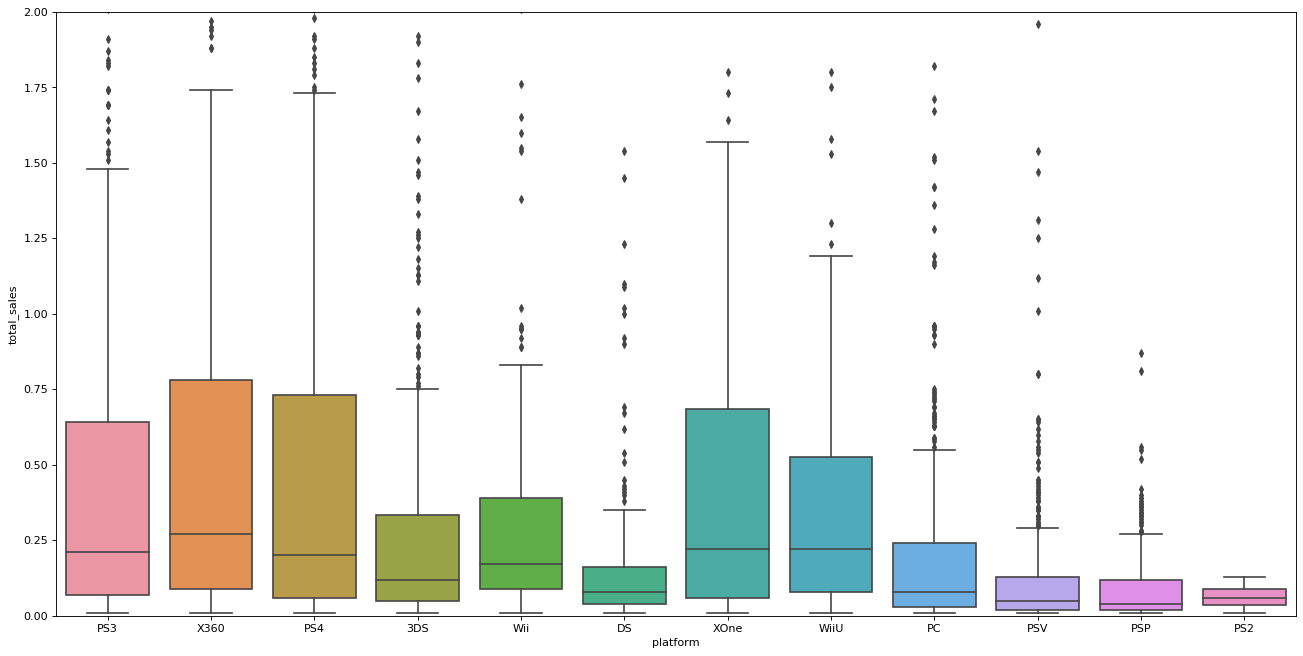

In [19]:
fig = plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.boxplot(x='platform', y='total_sales', data=name_sorted)
plt.ylim(0, 2)
plt.show()

Из графиков видно, что большинство игр для выбранных платформ за период с 2011 по 2016 не вышли за миллион долларов, хотя есть и много выбросов. Выведем список данных игр на экран: 

In [20]:
display(name_sorted[name_sorted['total_sales'] > 1].head(10))

,platform,name,total_sales
0,PS3,Grand Theft Auto V,21.05
1,X360,Grand Theft Auto V,16.27
2,X360,Call of Duty: Modern Warfare 3,14.73
3,PS4,Call of Duty: Black Ops 3,14.63
4,3DS,Pokemon X/Pokemon Y,14.60
5,PS3,Call of Duty: Black Ops II,13.79
6,X360,Call of Duty: Black Ops II,13.68
7,PS3,Call of Duty: Modern Warfare 3,13.33
8,3DS,Mario Kart 7,12.65
9,PS4,Grand Theft Auto V,12.62


Как мы можем видеть, таких игр аж 445 и самой продаваемой игрой является гта 5. 

Теперь посчитаем, сколько игр в было выпущено на каждую из платформ

In [21]:
display(df.groupby('platform')['name'].count().reset_index().sort_values('name', ascending=False))

,platform,name
4,PS3,708
0,3DS,512
10,X360,498
7,PSV,429
5,PS4,392
2,PC,389
6,PSP,312
11,XOne,247
8,Wii,197
1,DS,184


Разница в продажах заметна. Например, консоли PS2, PSP, PSV, DS уже отжили свое. Игры на эти консоли продаются очень неохотно. А вот консоли PS3, PS4, Xbox360, XboxOne, WIIU наоборот "на коне". Продажи на эти консоли на хорошем уровне. Хотя, как мы помним из предыдущего графика, новое поколение консолей уже вытесняет предыдущее. 


Что же касается среднего уровня продаж — он для всех консолей лежит примерно на одном уровне и не сильно отличается от консоли к консоли. Наверное, можно выделить хбох360 на уровне остальных потому что только у этой консоли средний уровень продаж превышает 250 тысяч долларов для каждой игры.
Неужели Хbox лучше PlayStation?

Возможно, разброс в продажах от консоли к консоли в некоторой степени возникает из-за разницы в цене на одну игру. Для более старых платформ игры стоили дешевле, чем для платформ нового поколения. 

Так же более современные консоли обладали возможностью игры в мультиплеер через интернет, в отличие от консолей более старых поколений. Наверняка эта возможность отчасти так же повлияла на популярность платформы.

Возможно, разброс в продажах от консоли к консоли в некоторой степени возникает из-за разницы в цене на одну игру. Для более старых платформ игры стоили дешевле, чем для платформ нового поколения. 

Так же более современные консоли обладали возможностью игры в мультиплеер через интернет, в отличие от консолей более старых поколений. Наверняка эта возможность отчасти так же повлияла на популярность платформы.

## Шаг 4.7 Отзывы

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

Для начала посмотрим, как зависят продажи на пс4 и хбох360 от оценок критиков и пользователей. 
выделим данные по этим платформам в отдельные датафреймы:

In [22]:
ps4_rass = df[df['platform'] == 'PS4']
xbox_rass = df[df['platform'] == 'X360']

теперь рассчитаем корреляцию и построим диаграммы расеяния для пар:
1. продажи на пс4 и оценка критиков
2. продажи на пс4 и оценка пользователей
3. продажи на хбох360 и оценка критиков
4. продажи на хбох360 и оценка пользователей

значение корреляции между продажами и оценкой критиков для пс4: 0.406567902061781

значение корреляции между продажами и оценкой пользователей для пс4: -0.027427851974847168

значение корреляции между продажами и оценкой критиков для хбох360: 0.3912533245484554

значение корреляции между продажами и оценкой пользователей для хбох360: 0.03574576395877539


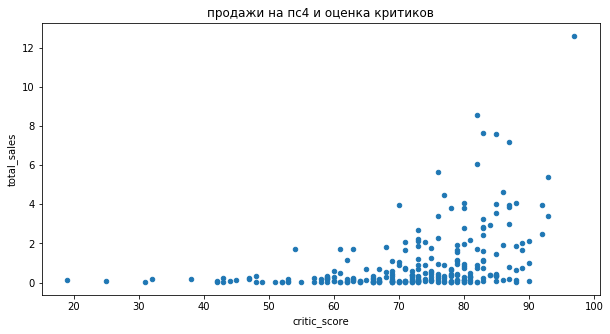

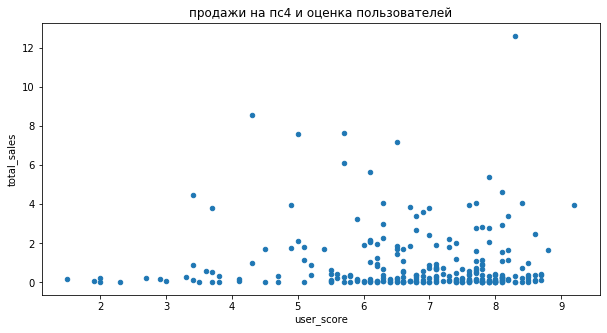

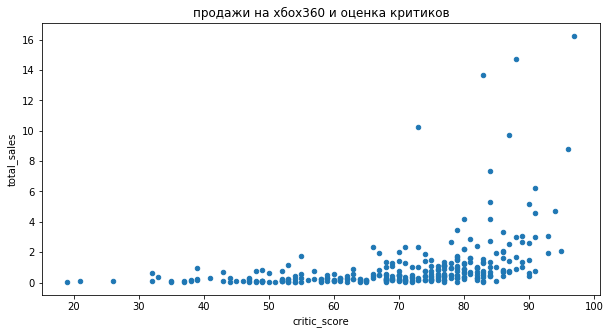

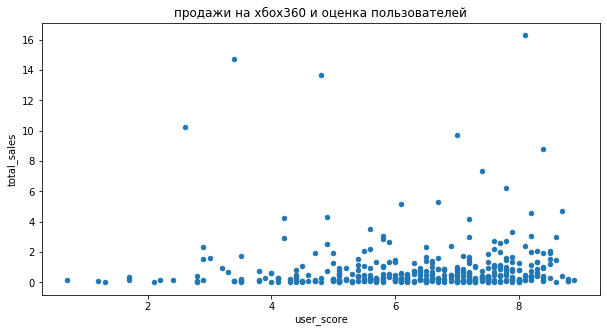

In [23]:
# Для все 4 пар действия аналогичны, так что я напишу комментари только к первой

# Строим диаграмму расеяния, где по оси х откладываем продажи, а по оси у откладываем оценку критиков
ps4_rass.plot(y='total_sales', x='critic_score', kind='scatter', title='продажи на пс4 и оценка критиков', figsize=(10,5))

# Считаем значение корреляции и выводим на экран:
print('значение корреляции между продажами и оценкой критиков для пс4:', ps4_rass['total_sales'].corr(ps4_rass['critic_score']))
print()

ps4_rass.plot(y='total_sales', x='user_score', kind='scatter', title='продажи на пс4 и оценка пользователей', figsize=(10,5))

print('значение корреляции между продажами и оценкой пользователей для пс4:', ps4_rass['total_sales'].corr(ps4_rass['user_score']))
print()

xbox_rass.plot(y='total_sales', x='critic_score', kind='scatter', title='продажи на хбох360 и оценка критиков', figsize=(10,5))

print('значение корреляции между продажами и оценкой критиков для хбох360:', xbox_rass['total_sales'].corr(xbox_rass['critic_score']))
print()

xbox_rass.plot(y='total_sales', x='user_score', kind='scatter', title='продажи на хбох360 и оценка пользователей', figsize=(10,5))

print('значение корреляции между продажами и оценкой пользователей для хбох360:', xbox_rass['total_sales'].corr(xbox_rass['user_score']))


Из графиков видно, что оценки критиков немного влияют на продажи, но вот оценки пользователей не влияют никак. 

Так, например, на графике 1 видно, что чем выше оценка критиков, тем больше сумарные продажи игр. Для хбох360 данную зависимость видно меньше, но тем не менее, она прослеживается. Для игр с оценкой критиков выше 70 наблюдается заметное повышение сумарных продаж. 

на графиках 2 и 4 можно заметить, что продажи не зависят от оценки пользователей, например  от оценки выше 3 продажи варьируются независимо. то есть по графику можно сказать, что корреляция есть только для оценок 1 и 2. Любопытно, что корреляция между оценкой пользователей и продажами игр на пс4 отрицательная. То есть оценка пользователей обратно влияет на сумму продаж игр на пс4. Хоть значение и невероятно маленькое, и влияния по сути нет, тем не менее, интересная закономерность. Может быть, имея больше данных, мы бы смогли выяснить более точно.

Так же хочу заметить, что я специально взял консоли разных поколений. Пс4 сильно моложе своего оппонента и на графиках видно, что для консолей нового поколения зависимость суммарных продаж от оценок критиков и пользователей выше, хоть и незначительно. Возможно, это связано с популяризацией рынка оценок.

Теперь посмотрим на весь датасет в целом:

значение корреляции между продажами и оценкой критиков: 0.3299765050114585

значение корреляции между продажами и оценкой пользователей: 0.026416558309792247


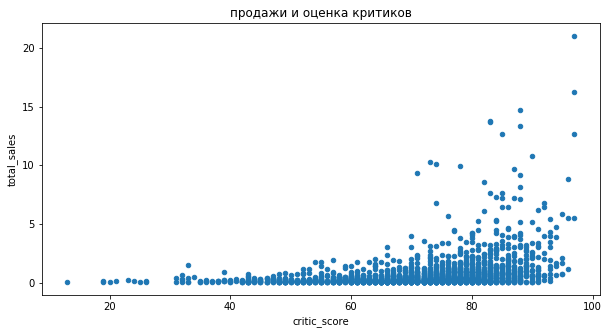

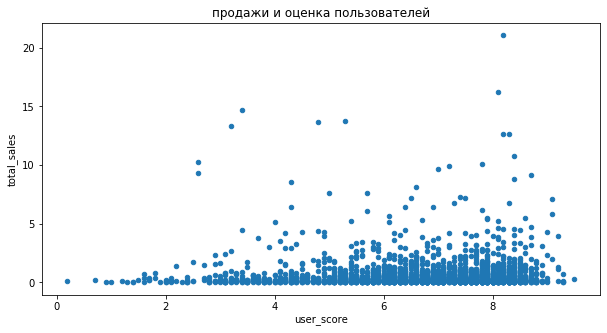

In [24]:
# Аналогичные действия, как и в предыдущей ячейке.

df.plot(y='total_sales', x='critic_score', kind='scatter', title='продажи и оценка критиков', figsize=(10,5))

print('значение корреляции между продажами и оценкой критиков:', df['total_sales'].corr(df['critic_score']))
print()

df.plot(y='total_sales', x='user_score', kind='scatter', title='продажи и оценка пользователей', figsize=(10,5))

print('значение корреляции между продажами и оценкой пользователей:', df['total_sales'].corr(df['user_score']))

В целом, картина аналогична. 

Зависимость продаж от оценок критиков есть, но незначительная. А вот зависимости продаж от оценок пользователей фактически нет.

Можно с уверенность сказать, что для всех консолей из нашего списка данное правило сохраняется.

Лично мне кажется, что у людей меньше степень доверия к оценкам пользователей, чем к оценке критиков. Критики выставляют оценки объективно по определенным оговоренным параметрам, а пользователи на основе субъективных мнений. 

Плюс оценка критиков выставляется либо до выхода игры либо первое время после выхода, а пользователи ставят свои оценки уже после того, как приобрели игру. 

## Шаг 4.8 Распределение игр по жанрам

Теперь посмотрим на общее распределение игр по жанрам.

In [25]:
# Получим таблицу с нужными данными
pt1 = df.groupby('genre').agg({'name': 'count','total_sales': 'sum'})

# Обновим индекс чтоб переименовать столбцы
pt1 = pt1.reset_index()

# Установим новые названия для столбцов
pt1.set_axis(['genre', 'games_count', 'sales_sum'], axis=1, inplace=True)

# Добавим столбец, который показывает соотношение итоговой суммы продаж с количеством проданных игр
pt1['relation'] = pt1['sales_sum'] / pt1['games_count']

# Отсортируем данные по этому стоблбцу и выведем таблицу на экран
pt1.sort_values('relation', ascending=False, inplace=True)
display(pt1)

,genre,games_count,sales_sum,relation
8,Shooter,329,402.91,1.224650
4,Platform,122,88.68,0.726885
10,Sports,389,237.15,0.609640
7,Role-Playing,465,245.63,0.528237
6,Racing,180,88.31,0.490611
0,Action,1269,557.80,0.439559
2,Fighting,159,66.90,0.420755
3,Misc,375,139.42,0.371787
9,Simulation,136,50.26,0.369559
11,Strategy,117,22.16,0.189402


Как мы видим, самые прибыльные игры, за явным отрывом - шутеры, однако возможно это обусловленно успешностью нескольких игр, например - серией COD. 50 миллионов суммарно принесли игры black ops 3, black ops 2 и ghosts. А это больше 15 процентов от суммы всех продаж игр. но тем не менее, в среднем на одну игру приходится 1.2 млн долларов.

На втором месте идут платформеры, на третьем — спортивные. Что для тех, что для тех средние продажи с одной игры примерно равны. 727 и 600 тысяч долларов с каждой игры соответственно. 

Самый крупный жанр по количеству игр — экшон игры. Больше тысячи игр было выпущено с 2011 по 2016 годы. однако прибыльным его не назовешь. В среднем каждая игра приносит по 430 тысяч долларов. Однако более детальный анализ покажет, что и там есть свои лидеры — например серия GTA. Продажи одной только GTA 5 составили почти 50 миллионов долларов.

# Шаг 5. Портрет пользователя
<a id='portrait'></a>

Так как рейтинг определяется буквенными значениями, введем классификатор для того, чтоб в дпальнейшем построить график:

1. 'unknown' , 'RP' = 0
2. 'E'= 1
3. 'E10+' = 2
4. 'T' = 3
5. 'M' = 4

Избавимся от значений 'unknown' и 'RP'. Так как мы не можем определить рейтинг этих игр, то будем работать только с теми, для которых рейтинг известен. 

In [26]:
print(df['rating'].unique())
df['rating'] = df['rating'].replace({'unknown': '0', 'RP': '0', 'E': '1', 'EC': '2', 'E10+': '3', 'T': '4', 'M': '5'})
df = df.astype({'rating': 'int64'})
print(df['rating'].unique())

['M' 'unknown' 'E' 'E10+' 'T' 'EC' 'RP']
[5 0 1 3 4 2]


Выведем на экран топ 5 самых популярных платформ и топ 5 самых популярных жанров в соответствии с продажами в Северной Америке.

А так же построим диаграмму рассеяния для рейтинга и уровня продаж.

In [27]:
def pols(region):
# Таблица распределения по платформам

    # Для начала сохраним нужные данные в отдельный датафрейм
    na_plat = df.groupby('platform')[region].sum().reset_index().sort_values(region, ascending=False)

    # посчитаем сумму продаж для дальнейших расчетов
    na_plat_summ = na_plat[region].sum()

    # посчитаем в отдельном столбце долю продаж по платформам
    na_plat['sales_part'] = na_plat[region] / na_plat_summ

  # построим круговую диаграмму
    
    # для того, чтобы избавиться от мелких значений на диаграмме, ограничим ее первыми 5 платформами
    
    # сохраним в отдельный датафрейм первые 5 платформ по доли продаж
    df2 = na_plat[:5].copy()
    
    # отдельным значением сохраним сумму значений для платформ, которые не попали в топ5
    new_row = pd.DataFrame(data = {
        'platform' : ['others'],
        'sales_part' : [na_plat['sales_part'][5:].sum()]
    })

    # Добавим значение others в наш скопированный датафрейм
    df2 = pd.concat([df2, new_row], sort=True)

    # и выведем круговую диаграмму на экран
    df2.plot(kind = 'pie', y = 'sales_part', labels = df2['platform'], autopct='%1.1f%%', figsize=(15,8))
    plt.legend(loc="center right")
    plt.title('Распределение продаж по платформам в процентах')
    plt.show()
    
    
#Таблица распределения по жанрам

    # Для начала сохраним нужные данные в отдельный датафрейм
    na_genre = df.groupby('genre')[region].sum().reset_index().sort_values(region, ascending=False)

    # посчитаем сумму продаж для дальнейших расчетов
    na_genre_summ = na_genre[region].sum()

    # посчитаем в отдельном столбце долю продаж по жанрам
    na_genre['sales_part'] = na_genre[region] / na_genre_summ

  # построим круговую диаграмму
    
    # для того, чтобы избавиться от мелких значений на диаграмме, ограничим ее первыми 5 платформами
    
    # сохраним в отдельный датафрейм первые 5 платформ по доли продаж
    df2 = na_genre[:5].copy()
    
    # отдельным значением сохраним сумму значений для платформ, которые не попали в топ5
    new_row = pd.DataFrame(data = {
        'genre' : ['others'],
        'sales_part' : [na_genre['sales_part'][5:].sum()]
    })

    # Добавим значение others в наш скопированный датафрейм
    df2 = pd.concat([df2, new_row], sort=True)

    # и выведем круговую диаграмму на экран
    df2.plot(kind = 'pie', y = 'sales_part', labels = df2['genre'], autopct='%1.1f%%', figsize=(16,8))
    plt.legend(loc="center right")
    plt.title('Распределение продаж по жанрам в процентах')
    plt.show()

    
    
# диаграмма рассеяния, где по оси х выводятся значения рейтинга, а по оси у продажи
    df.plot(x='rating', y=region, kind='scatter', title='Влияние рейтинга ESRB на продажи', figsize=(10,5))
    plt.show()

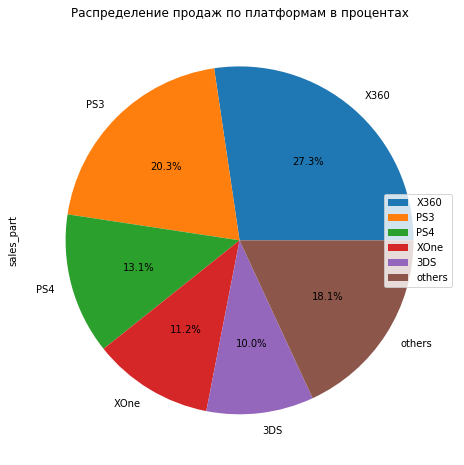

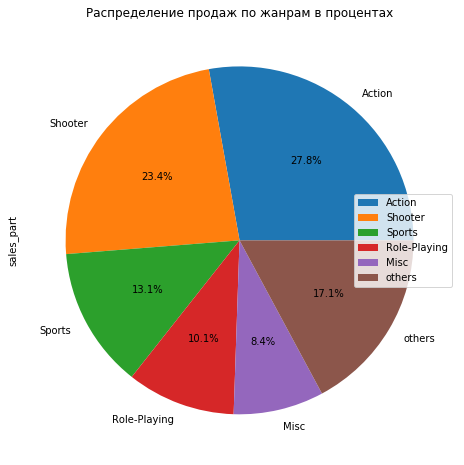

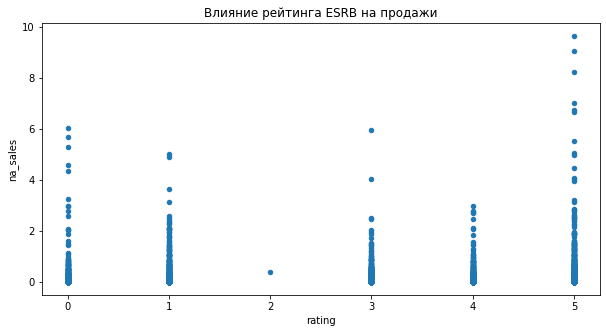

In [28]:
pols('na_sales')

Самой популярной консолью в Северной Америке с 2011 по 2016 год являлась Xbox360, на нее приходилось почти 27% всех продаж. На втором месте PS3 с 20%, на 3 - PS4 с 13%. 

Самым популярным жанром был жанр "экшон". Более 27% продаж были получены с игр этого жанра. На втором месте оказались игры жанра шутеры, их доля составила более 23%. На 3 месте оказались спортивные игры с долей в 13%.

как видно из графика, в Северной Америке игры рейтинга mature продаются чуть лучше, чем остальные. Однако игры без рейтинга не сильно отстают от игр с рейтингом mature. Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.

Выведем на экран топ 5 самых популярных платформ и топ 5 самых популярных жанров в соответствии с продажами в Европе.

А так же построим диаграмму рассеяния для рейтинга и уровня продаж.

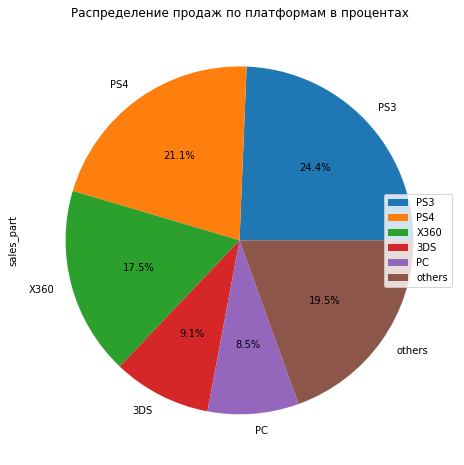

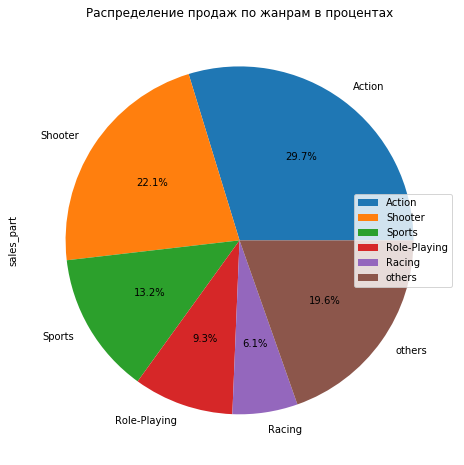

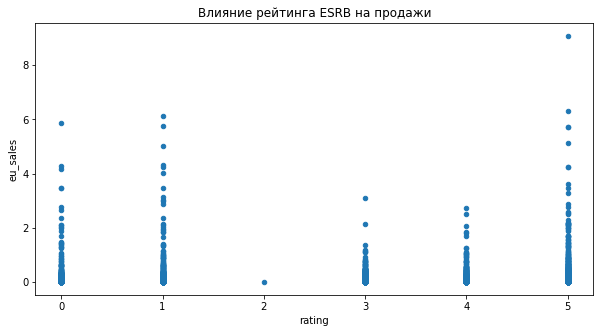

In [29]:
pols('eu_sales')

Самой популярной консолью в Европе с 2011 по 2016 год была PS3, на нее приходилось более 24% всех продаж. На втором месте PS4 с 21%, на 3 - Xbox360 с 17,5%. 

Самым популярным жанром был жанр "экшон". Более 29% продаж были получены с игр этого жанра. На втором месте оказались игры жанра шутер, их доля составила более 22%. На 3 месте оказались спортивные игры с долей в 13%.

Как видно из графика, в Европе игры рейтинга mature и everyone, а так же игры без рейтинга продаются чуть лучше, чем остальные. Однако игры без рейтинга продаются не сильно хуже. Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.

Выведем на экран топ 5 самых популярных платформ и топ 5 самых популярных жанров в соответствии с продажами в Японии.

А так же построим диаграмму рассеяния для рейтинга и уровня продаж.

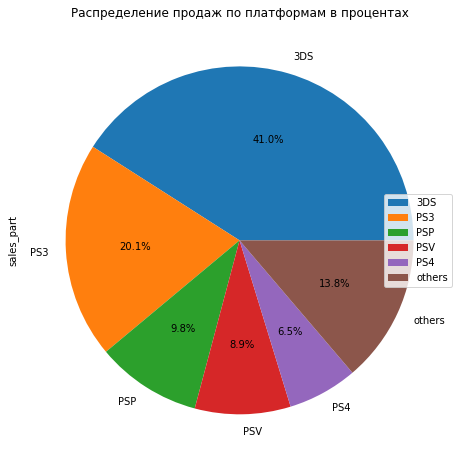

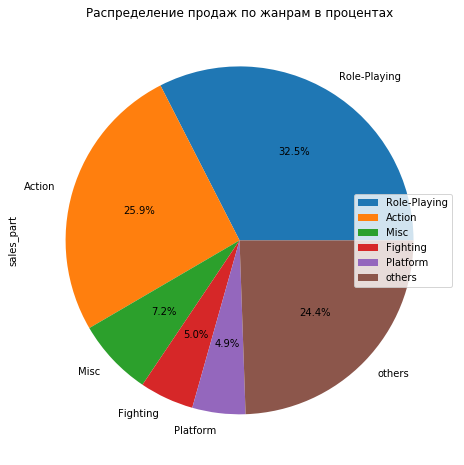

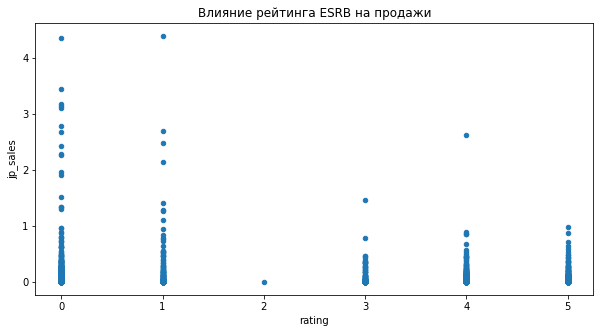

In [30]:
pols('jp_sales')

Самой популярной консолью в Японии с 2011 по 2016 год была 3DS, на нее приходился 41% всех продаж. на втором месте PS3 с 20%, на 3 - PSP с почти 10%. 

Самым популярным жанром был жанр "рпг". Более 32% продаж были получены с игр этого жанра. На втором месте оказались игры жанра "экшон", их доля составила почти 26%. На 3 месте оказались игры жанра "Миск" с долей всего в 7%. Для японии, в отличие от Северной Америки и Европы, жанр РПГ сильно выделяется по отношению к остальным. Возможно, это связано с менталитетом людей в данной стране.

Игры без рейтинга продаются в Японии заметно лучше, чем игры с любым другим рейтингом . Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.

## Шаг 6. Исследование статистических показателей
<a id='stat'></a>

Посмотрим как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы.

In [31]:
def stat(genre):
    # Оценка критиков
    critic_by_genre = df[df['genre'] == genre]['critic_score'].dropna()
    
    # расчет среднего
    mu = critic_by_genre.mean()
    
    # расчет дисперсии
    var = critic_by_genre.var()
    
    # расчет стандартного отклонения
    std = critic_by_genre.std()

    # график гистограммы
    plt.hist(critic_by_genre, bins=25, density=True, alpha=0.6, color='g')

    # график нормального распределения
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "среднее = %.2f,  стандартное отклонение = %.2f, дисперсия = %.2f" % (mu, std, var)
    plt.title(title)
    print('Для оценок критиков')
    plt.show()
    
    # расчет медианы
    print('медиана =', critic_by_genre.median())
    print()
    # Оценка пользователей
    user_by_genre = df[df['genre'] == genre]['user_score'].dropna()
    
    # расчет среднего
    mu_u = user_by_genre.mean()
    
    # расчет дисперсии
    var_u = user_by_genre.var()
    
    # расчет стандартного отклонения
    std_u = user_by_genre.std()

    # график гистограммы
    plt.hist(user_by_genre, bins=25, density=True, alpha=0.6, color='g')

    # график нормального распределения
    xmin_u, xmax_u = plt.xlim()
    x_u = np.linspace(xmin_u, xmax_u, 100)
    p_u = norm.pdf(x_u, mu_u, std_u)
    plt.plot(x_u, p_u, 'k', linewidth=2)
    title_u = "среднее = %.2f,  стандартное отклонение = %.2f, дисперсия = %.2f" % (mu_u, std_u, var_u)
    plt.title(title_u)
    print('Для пользовательских оценок')
    plt.show()
    
    # расчет медианы
    print('медиана =',user_by_genre.median())

Для оценок критиков


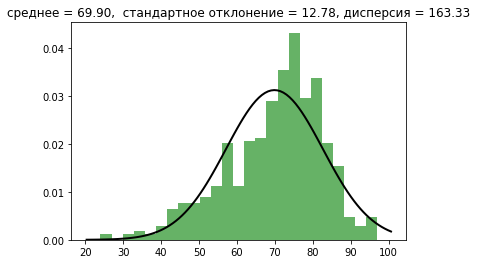

медиана = 72.0

Для пользовательских оценок


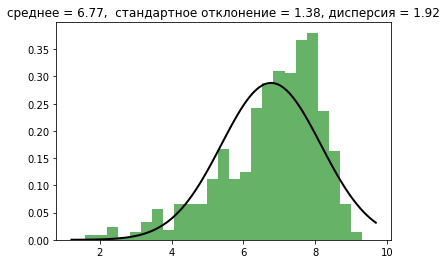

медиана = 7.1


In [32]:
stat('Action')

Для жанра Экшон оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 70 до 80. Пик однако все же ближе к 70.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7 до 8. Но в отличие от критиков, пик оценок пользователей ближе к 8.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


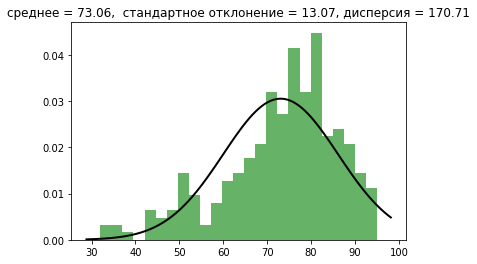

медиана = 75.5

Для пользовательских оценок


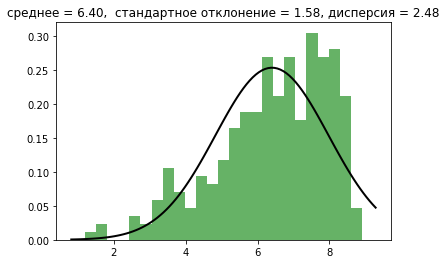

медиана = 6.7


In [33]:
stat('Shooter')

Для жанра Шутер оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 75 до 85. Пик находится ближе к 85.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7,5 до 8,5. Пик оценок пользователей ближе к 8,5.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


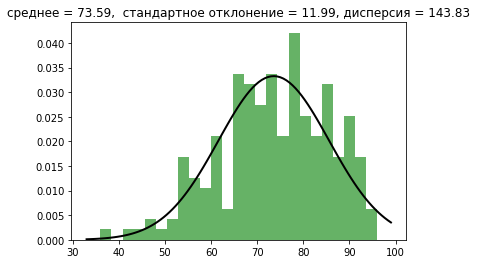

медиана = 74.0

Для пользовательских оценок


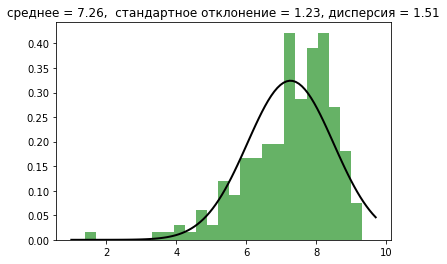

медиана = 7.5


In [34]:
stat('Role-Playing')

Для жанра РПГ оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 65 до 78. Пик однако все же ближе к 78.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 6,5 до 8,5. Но в отличие от критиков, пик оценок пользователей ближе к 8,5.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


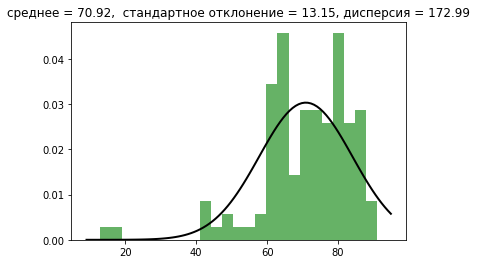

медиана = 73.0

Для пользовательских оценок


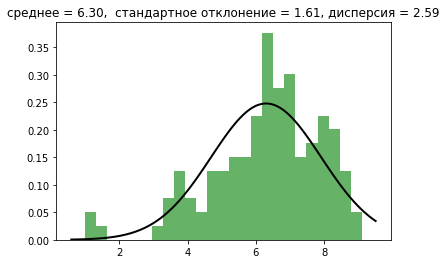

медиана = 6.4


In [35]:
stat('Racing')

Для жанра Гонки оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 60 до 65 и в районе 80. Пика в данном жанре 2. Один ближе к 65, второй ближе к 80.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 6 до 7. Но в отличие от критиков, пик оценок пользователей всего один и располагается он ближе к 6,5.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


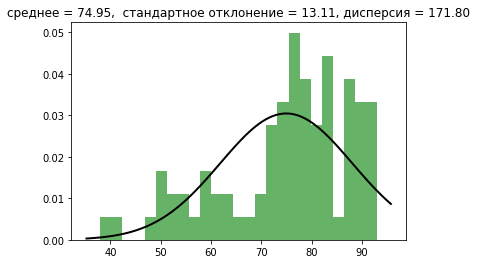

медиана = 77.0

Для пользовательских оценок


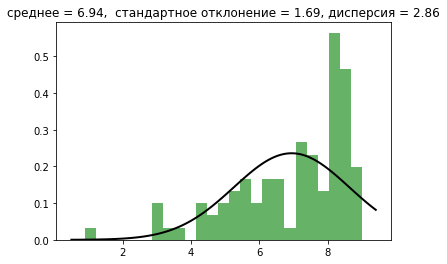

медиана = 7.5


In [36]:
stat('Platform')

Для жанра Платформеры оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 75 до 95. Пик однако все же ближе к 75.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7 до 9. Но в отличие от критиков, пик оценок пользователей ближе к 8,5.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


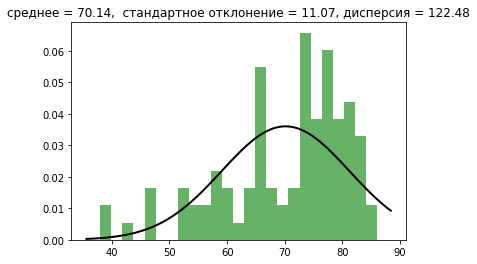

медиана = 73.0

Для пользовательских оценок


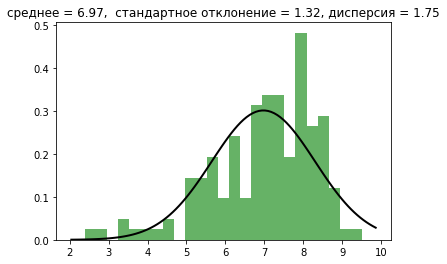

медиана = 7.2


In [37]:
stat('Misc')

Для жанра МИСК оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 75 до 85. Пик находится ближе к 75.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7 до 9. Но в отличие от критиков, пик оценок пользователей ближе к 8.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


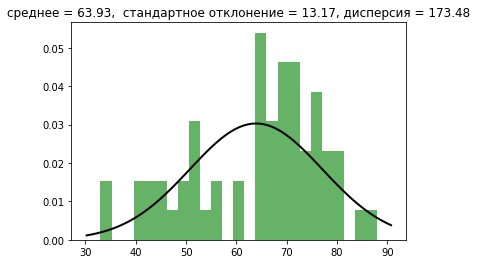

медиана = 66.0

Для пользовательских оценок


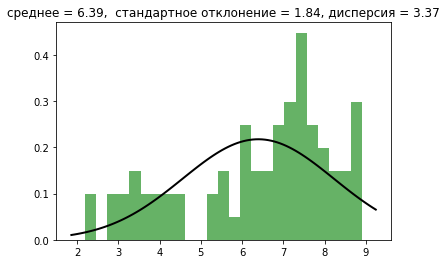

медиана = 7.0


In [38]:
stat('Simulation')

Для жанра Симуляции оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 65 до 70. Пик однако все же ближе к 65.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7 до 8. Но в отличие от критиков, пик оценок пользователей ближе к 7,5.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


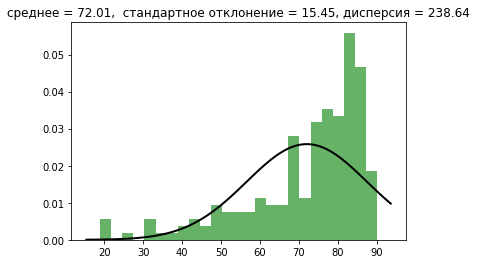

медиана = 77.0

Для пользовательских оценок


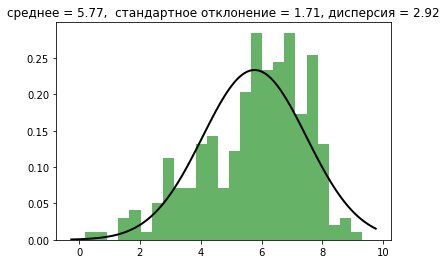

медиана = 6.1


In [39]:
stat('Sports')

Для жанра Спортивных игр оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 75 до 85. Пик все же ближе к 85.

Так как медиана сильно больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 5 до 8. Пика в данном жанре 2. Один ближе к 5, второй ближе к 7.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


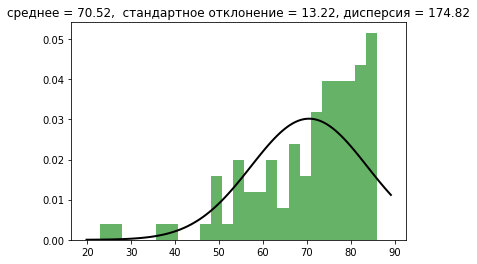

медиана = 74.0

Для пользовательских оценок


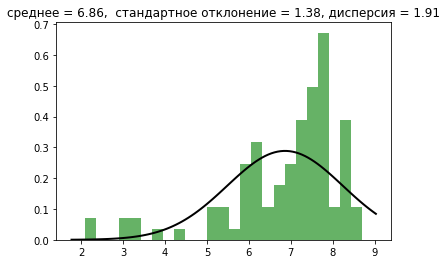

медиана = 7.3


In [40]:
stat('Fighting')

Для жанра Файтинги оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 75 до 85. Пик находится в районе 85.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7 до 8. Пик оценок пользователей ближе к 8.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


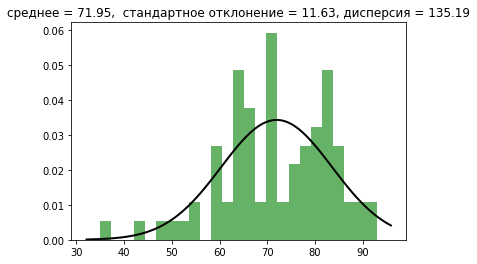

медиана = 72.0

Для пользовательских оценок


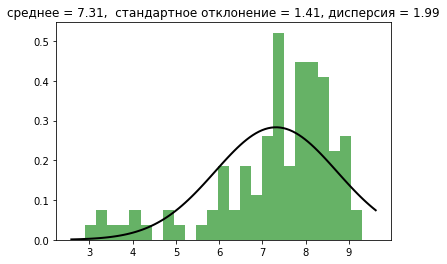

медиана = 7.7


In [41]:
stat('Adventure')

Для жанра Приключения оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 65, 70 и 85. Пик однако все же ближе к 70.

Так как медиана практически равна среднему, можно сделать вывод, что данные по оценкам критиков не сильно скошены в какую-либо из сторон. Игры данного жанра в среднем оцениваются критиками нормально. 

Оценки пользователей в основном сконцентрированны в диапазоне от 7,5 до 8,5. В целом, как и для оценок критиков, пик оценок пользователей ближе к 7.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


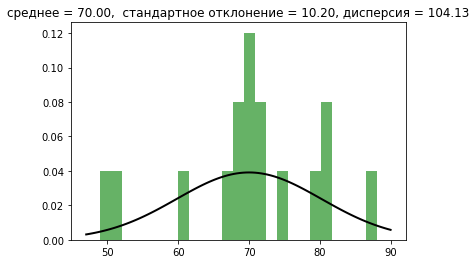

медиана = 70.0

Для пользовательских оценок


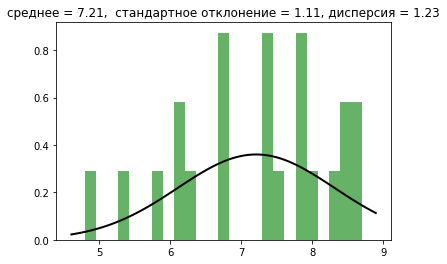

медиана = 7.4


In [42]:
stat('Puzzle')

Для жанра Пазлы оба графика совсем не похожи на нормальное распределение. 

Оценки критиков в основном сконцентрированны в районе 70. Пик так же находится в районе  70.

Так как медиана равна среднему, можно сделать вывод, что данные по оценкам критиков не скошены в какую-либо из сторон. Игры данного жанра в среднем оцениваются критиками нормально. 

Оценки пользователей в основном сконцентрированны в районе 6.8, 7.4 и 7.9. Пика в данном жанре 3. Все они располагаются в точках основной концентрации значений.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

Для оценок критиков


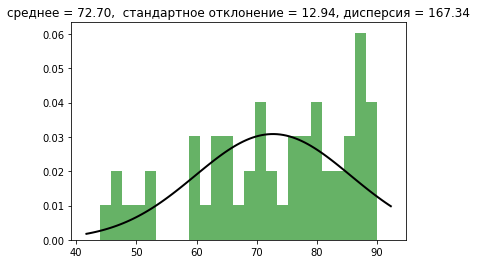

медиана = 75.5

Для пользовательских оценок


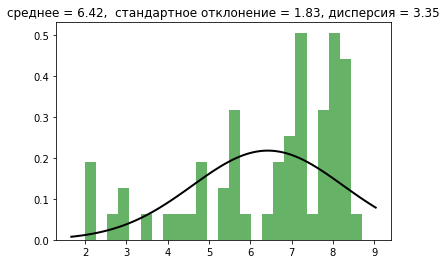

медиана = 7.1


In [43]:
stat('Strategy')

Для жанра Стратегии оба графика лишь отдаленно напоминают нормальное распределение. 

Оценки критиков в основном сконцентрированны в диапазоне от 60 до 90. Пик находится ближе к 88.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам критиков скошенны влево. Игры данного жанра в среднем оцениваются критиками высоко. 

Оценки пользователей в основном сконцентрированны в районе 7 и 8. Пика в данном жанре 2. Один ближе к 7.3, второй ближе к 7,9.

Так как медиана больше среднего, можно сделать вывод, что данные по оценкам пользователей скошенны влево. Игры данного жанра в среднем оцениваются пользователями высоко.

In [44]:
display(df.groupby('genre')['critic_score'].median().reset_index().sort_values('critic_score', ascending=False).head())
print()
display(df.groupby('genre')['user_score'].median().reset_index().sort_values('user_score', ascending=False).head())
print()
print()
display(df.groupby('genre')['critic_score'].mean().reset_index().sort_values('critic_score', ascending=False).head())
print()
display(df.groupby('genre')['user_score'].mean().reset_index().sort_values('user_score', ascending=False).head())

,genre,critic_score
4,Platform,77.0
10,Sports,77.0
8,Shooter,75.5
11,Strategy,75.5
2,Fighting,74.0


,genre,user_score
1,Adventure,7.7
4,Platform,7.5
7,Role-Playing,7.5
5,Puzzle,7.4
2,Fighting,7.3


,genre,critic_score
4,Platform,74.951220
7,Role-Playing,73.590909
8,Shooter,73.064516
11,Strategy,72.703704
10,Sports,72.005291


,genre,user_score
1,Adventure,7.314286
7,Role-Playing,7.260952
5,Puzzle,7.209091
3,Misc,6.973288
4,Platform,6.940860


### Общий вывод

##### Оценка китиков
Среди всех жанров, наиболее высокое медианное значение по оценкам критиков у жанров Sports и Platform с оценкой в 77.0. На третьем месте находится жанр Shooter с оценкой 75.5.

Наибольшее среднее значение у жанра Platform с оценкой в 74.9. На втором месте находится жанр Role-Playing с оценкой в 73.6, на третьем — Shooter с оценкой 73.0.

##### Оценка пользователей
Среди всех жанров, наиболее высокое медианное значение по оценкам пользователей у Adventure с оценкой в 7.7. На втором месте находятся жанры Platform и Role-Playing с оценкой в 7.5.

Наибольшее среднее значение у жанра Adventure с оценкой в 7.3. На втором месте находится жанр Role-Playing с оценкой чуть меньше чем 7.3, на третьем — Puzzle с оценкой 7.2.


## Шаг 7. Проверка гипотиз
<a id='hyp'></a>

Сначала проверим гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H0: Средний пользовательский рейтинг платформы Xbox One = среднему пользовательскому рейтингу платформы PC
H1: рейтинги не равны

In [45]:
# Для начала опять сохраним только необходимые данные в отдельные датафреймы и уберем пропуски
user_score_xbox = df[df['platform'] == 'XOne']['user_score'].dropna()
user_score_pc = df[df['platform'] == 'PC']['user_score'].dropna()


# Проведем проверку на равенство дисперсий
if user_score_xbox.var() == user_score_pc.var():
    print('Дисперсии равны, установить equal_var=True')
else:
    print('дисперсии не равны, установить equal_var=False')

print()

# Установим пороговое значение альфа 0.05
alpha = .05 

# Сохраним в переменную results результат проведения 
#двустороннего т-теста о равенстве средних для 2 независимых выборок
results = st.ttest_ind(
    user_score_xbox, 
    user_score_pc,
    equal_var=False)

# Выведем p-value для нашего т-теста
print('p-значение:', results.pvalue)

# сравним получившееся p-value с пороговым значением альфа и на основании этого решим
# отвергать ли нулевую гипотезу или нет
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

дисперсии не равны, установить equal_var=False

p-значение: 0.6667617094742546
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось, соответственно делаем вывод, что с вероятностью в почти 67% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними пользовательскими рейтингами платформ Xbox One и PC.

Теперь проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные.

H0: Средний пользовательский рейтинг жанра Action = среднему пользовательскому рейтингу жанров Sports
H1: рейтинги не равны

In [46]:
# Для начала опять сохраним только необходимые данные в отдельные датафреймы и уберем пропуски
user_score_action = df[df['genre'] == 'Action']['user_score'].dropna()
user_score_sport = df[df['genre'] == 'Sports']['user_score'].dropna()

# Проведем проверку на равенство дисперсий
if user_score_action.var() == user_score_sport.var():
    print('Дисперсии равны, установить equal_var=True')
else:
    print('дисперсии не равны, установить equal_var=False')

print()

# Установим пороговое значение альфа 0.01
alpha = .01

# Сохраним в переменную results результат проведения 
#двустороннего т-теста о равенстве средних для 2 независимых выборок
results1 = st.ttest_ind(
    user_score_action, 
    user_score_sport, 
    equal_var=False)

# Выведем p-value для нашего т-теста
print('p-значение:', results1.pvalue)

# сравним получившееся p-value с пороговым значением альфа и на основании этого решим
# отвергать ли нулевую гипотезу или нет
if (results1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

дисперсии не равны, установить equal_var=False

p-значение: 1.6333844760832802e-16
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергнуть получилось, соответственно делаем вывод, что с вероятностью в 99% такой результат мы получили не случайно и средние пользовательские рейтинги жанров Action и Sports отличаются.

Гипотезы в обоих случаях я формулировал так, чтоб нулевая гипотеза говорила о равенстве средних двух совокупностей, а альтернативная о неравенстве.

Так как:
1. данные кличественные
2. выборки являются независимыми
3. выборок всего 2

И несмотря на то, что данные распределены не нормально, я проводил проверку используя т-тест.

Ниже результаты проверки по Манна-Уиттни.

## Дополнительная проверка

In [47]:
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro

In [48]:
def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('raspredelenie normalnoye')
    else:
        print('raspredelenie ne normalnoe')

In [49]:
Shapiro_Wilk(user_score_xbox)
print()
Shapiro_Wilk(user_score_pc)
print()
Shapiro_Wilk(user_score_action)
print()
Shapiro_Wilk(user_score_sport)

Statistics=0.955, p=0.000
raspredelenie ne normalnoe

Statistics=0.941, p=0.000
raspredelenie ne normalnoe

Statistics=0.925, p=0.000
raspredelenie ne normalnoe

Statistics=0.961, p=0.000
raspredelenie ne normalnoe


In [50]:
def mw(data1,data2):
    stat, p = mannwhitneyu(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [51]:
mw(user_score_xbox, user_score_pc)

Statistics=28294.000, p=0.380
Same distribution (fail to reject H0)


In [52]:
mw(user_score_action, user_score_sport)

Statistics=59880.500, p=0.000
Different distribution (reject H0)


Манна-Уиттни показал аналогичные результататы, так что выводы для обеих гипотез остаются теми же.

## Шаг 8. Общие выводы

### 1. Подготовка данных
Данные были очищены от пропущенных значений. Названия столбцов были изменены на более удобные. Типы данных в столбцах год выпуска и оценка пользователей были заменены.

### 2. Исследовательский анализ

#### В рамках исследовательского анализа:
1. Были рассмотрены данные о количестве выпускаемых игр в год;
2. Были установлены консоли, для которых продажи на момент 2016 года оказались на нуле

> **все, кроме PS4, XBoxOne, 3DS, WIIU и PC**. 

3. Была установленна средняя продолжительность жизни платформы

> **8-10 лет**;

4. Были установленны границы по году выпуска, в которых находятся наиболее актуальные для нализа данные

> **2011-2016**;

5. Были установленны потенциально прибыльные платфоры:

> Самые перспективные консоли для Северной Америки и Европы — PS4 и Xbox One. Как в целом и для всего мира, кроме Японии и, возможно, остальных восточно-азиатских стран. В Японии самой популярной консолью стала 3DS, а так же там популярна продукция компании PlayStation и совсем непопулярна продукция компании Xbox. Ближайшие года 4 на рынке вряд ли появятся новые консоли, так что акцент стоит сделать на самое молодое поколение консолей;

6. Была описана разница в глобальных продажах каждой игры с разбивкой по платформам;

> Разница в продажах заметна. Например, консоли PS2, PSP, PSV, DS уже отжили свое. Игры на эти консоли продаются очень неохотно. А вот консоли PS3, PS4, Xbox360, XboxOne, WIIU наоборот "на коне". Продажи на эти консоли на хорошем уровне. Хотя, как мы помним, новое поколение консолей уже вытесняет предыдущее.

> Что же касается среднего уровня продаж — он для всех консолей лежит примерно на одном уровне и не сильно отличается от консоли к консоли. Наверное, можно выделить хбох360 на уровне остальных потому что только у этой консоли средний уровень продаж превышает 250 тысяч долларов для каждой игры.

> Возможно, разброс в продажах от консоли к консоли в некоторой степени возникает из-за разницы в цене на одну игру. Для более старых платформ игры стоили дешевле, чем для платформ нового поколения. 

> Так же более современные консоли обладали возможностью игры в мультиплеер через интернет, в отличие от консолей более старых поколений. Наверняка эта возможность отчасти так же повлияла на популярность платформы.

7. Было определено влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

> **Eсть небольшое влияние на продажи оценки критиков, а для оценки пользователей влияния нет**;

8. Были установлены жанры с высокими и низкими продажами

> Самый популярный жанр — Экшон. В Северной Америке, Европе и Японии он входит в топ 2 самых популярных жанров. На втором месте в Северной Америке и Европе шутеры. На третьем — спортивные игры. В Японии же самую большую долю игр покупают в жанре Role-Playing. Так что в японские магазины стоит закупать больше рпг.

### 3. Составление портрета пользователя для каждого региона

Были составлены портреты пользователей для регионов:
1. **Северная Америка**;

> Самой популярной консолью в Северной Америке с 2011 по 2016 год являлась Xbox360, на нее приходилось почти 27% всех продаж. На втором месте PS3 с 20%, на 3 - PS4 с 13%.

> Самым популярным жанром был жанр "экшон". Более 27% продаж были получены с игр этого жанра. На втором месте оказались игры жанра шутеры, их доля составила более 23%. На 3 месте оказались спортивные игры с долей в 13%.

> В Северной Америке игры рейтинга mature продаются чуть лучше, чем остальные. Однако игры без рейтинга не сильно отстают от игр с рейтингом mature. Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.

2. **Европа**;

> Самой популярной консолью в Европе с 2011 по 2016 год была PS3, на нее приходилось более 24% всех продаж. На втором месте PS4 с 21%, на 3 - Xbox360 с 17,5%.

> Самым популярным жанром был жанр "экшон". Более 29% продаж были получены с игр этого жанра. На втором месте оказались игры жанра шутер, их доля составила более 22%. На 3 месте оказались спортивные игры с долей в 13%.

> B Европе игры рейтинга mature и everyone, а так же игры без рейтинга продаются чуть лучше, чем остальные. Однако игры без рейтинга продаются не сильно хуже. Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.

3. **Япония**.

> Самой популярной консолью в Японии с 2011 по 2016 год была 3DS, на нее приходился 41% всех продаж. на втором месте PS3 с 20%, на 3 - PSP с почти 10%. 

> Самым популярным жанром был жанр "рпг". Более 32% продаж были получены с игр этого жанра. На втором месте оказались игры жанра "экшон", их доля составила почти 26%. На 3 месте оказались игры жанра "Миск" с долей всего в 7%. Для японии, в отличие от Северной Америки и Европы, жанр РПГ сильно выделяется по отношению к остальным. Возможно, это связано с менталитетом людей в данной стране.

> B Японии заметно лучше, чем игры с любым другим рейтингом . Из чего можно сделать вывод, что рейтинг никак не влияет на продаваемость игр.


### 4. Исследование статистических показателей
Было определено как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах. Посчитано среднее количество, дисперсия и стандартное отклонение. Построены гистограммы.

**Оценка китиков**

> Среди всех жанров, наиболее высокое медианное значение по оценкам критиков у жанров Sports и Platform с оценкой в 77.0. На третьем месте находится жанр Shooter с оценкой 75.5.

> Наибольшее среднее значение у жанра Platform с оценкой в 74.9. На втором месте находится жанр Role-Playing с оценкой в 73.6, на третьем — Shooter с оценкой 73.0.

**Оценка пользователей**

> Среди всех жанров, наиболее высокое медианное значение по оценкам пользователей у Adventure с оценкой в 7.7. На втором месте находятся жанры Platform и Role-Playing с оценкой в 7.5.

> Наибольшее среднее значение у жанра Adventure с оценкой в 7.3. На втором месте находится жанр Role-Playing с оценкой чуть меньше чем 7.3, на третьем — Puzzle с оценкой 7.2.

### 5. Проверка гипотиз
Были проверены гипотезы
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
> **Верно**;
2. Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные
> **Верно**.

### 6. Дополнительная информация

Во всем мире очень популярны игры GTA и COD. Возможно стоит закупать игр этих серий побольше.